# **Quantized Auto-Encoder By Sajjad Roohi**

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
import cv2
import matplotlib.pyplot as plt
import os


In [ ]:
!pip install QKeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4913 sha256=e8d75d19afe63b54697df936d057e1b9fbc3a961fa5da6c0b4962c49d940d5b0
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18154 sha256=a78deba0b958eecf42ddafa98b1fb9c3f43613456070c2b562f03c56b2bf5f2b
  Stored in directory: /root/.cache/pip/wheels/3f/10/c8/5023ea72290855ee33e7bc403e1048ae238b9c2fdb549a9f51
Successfully built pyparser parse


In [ ]:
import numpy as np

# **Utils**

In [ ]:
def fp_quantize(x, w, f):
    """
    fixed point post quantization.
    Args:
        x: floating point (can be list) 32 bit input
        w: bit width of the target fixed point
        f: fraction bit width of the target fixed point
    Returns:
        the desired fixed point quantized of the input x
    """
    i = w - f
    max = float(2 ** (i - 1) - 2 ** (-f))
    min = float(-2 ** (i - 1))
    n = float(2 ** f)
    xx = np.floor(x * n + 0.5) / n
    clipped = np.clip(xx, a_min=min, a_max=max)
    return clipped

In [ ]:
fp_quantize(.2340654, 9, 7)

0.234375

In [ ]:
def FPToHex(x, w = 8, f = 7):
    """
    Converts a given Fixed point number to its Hex representation.
    Args:
        x: fixed point having w bits and f bits fraction input
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        Hex representation of input
    """
    x_fix = x
    x_fix = x_fix * pow(2, f)
    x_fix = int(x_fix)
    if(x_fix < 0):
        binary = bin(x_fix+(1<<w))
    else:
        binary = bin(x_fix)
    return hex(int(binary, 2))[2:]

def WriteFixPToFile(file_name, data_fp, w = 8, f = 7, mode = "w"):
    """
    Writes given Fixed point numbers specified by w bits width and f bits fraction to the given file name.
    Args:
        file_name: file name to save the output
        data_fp: fixed point list having w bits and f bits fraction input
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        None
    """
    with open(file_name, mode) as file:
        for i in range(data_fp.shape[0]):
            file.write(str(FPToHex(data_fp[i], w=w, f=f))+'\n')

Use below function if needed (like verifying outputs or debugging).

In [ ]:
def twos_complement(bin_num):
    """
    calculates the 2's complement of the given binary number.
    Args:
        bin_num: binary number in string format
    Returns:
        the binary representation after performing 2's complement
    """

    # Perform 2's complement on the binary number
    flipped = ''
    for bit in bin_num:
        flipped += '0' if bit == '1' else '1'
    comp_num = int(flipped, 2) + 1

    return bin(comp_num)[2:].zfill(len(bin_num))

def fixed_point_to_float(bin_num, w=16, f=14):
    """
    Converts a fixed point number given in binary representation to its decimal floating point.
    Args:
        bin_num: binary number in string format
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        decimal floating point
    """
        # Check if the number is negative
    sign_bit = int(bin_num[0])
    if sign_bit:
        bin_num = twos_complement(bin_num, w, f)

    # Split the binary number into integer and fractional parts
    if f > 0:
        if f == w:
            float_num = int(bin_num, 2) / 2**f
        else:
            int_part = int(bin_num[:-f], 2)
            frac_part = int(bin_num[-f:], 2) / 2**f
            float_num = int_part + frac_part
    else:
        int_part = int(bin_num, 2)
        float_num = int_part

    # Apply the sign to the floating point number if it was negative
    if sign_bit:
        float_num = -float_num

    return float_num

def hex_to_fixed_point_decimal(hex_value, w, f):
    """
    Converts a fixed point number given in hex representation to its decimal floating point.
    Args:
        hex_value: hex number in string format
        w: bit width of the input
        f: fraction bit width of the input
    Returns:
        decimal floating point
    """
    binary_value = bin(int(hex_value, 16))[2:]

    # # Determine the sign bit
    binary_value = binary_value.zfill(w)

    # return decimal_value
    return fixed_point_to_float(binary_value, w, f)

# **Data Preparation**

load and normalize data images:

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


display images:

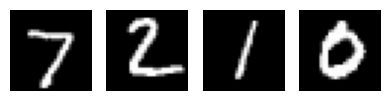

In [ ]:
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

network constants:

In [ ]:
LATENT_SAPCE_DIM = 32
LATENT_SPACE_WIDTH = 4
LATENT_SAPCE_HEIGHT = 8

reshape images to one dimensional shape:

In [ ]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# **Training**

define the autoencoder model:

In [ ]:
input_img = keras.Input(shape=(x_train.shape[1],))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(LATENT_SAPCE_DIM, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

define encoder:

In [ ]:
encoder = keras.Model(input_img, encoded)

define decoder:

In [ ]:
encoded_input = keras.Input(shape=(LATENT_SAPCE_DIM,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer)

train the model:

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 3s 6ms/step - loss: 0.2416 - val_loss: 0.1619
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1455 - val_loss: 0.1315
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1276 - val_loss: 0.1218
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1191 - val_loss: 0.1142
Epoch 5/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1134 - val_loss: 0.1098
Epoch 6/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1093 - val_loss: 0.1059
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1056 - val_loss: 0.1030
Epoch 8/100
235/235 [==============================] - 1s 6ms/step - loss: 0.1028 - val_loss: 0.1010
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1007 - val_loss: 0.0991
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.0990 - val_lo

In [ ]:
autoencoder.metrics_names

['loss']

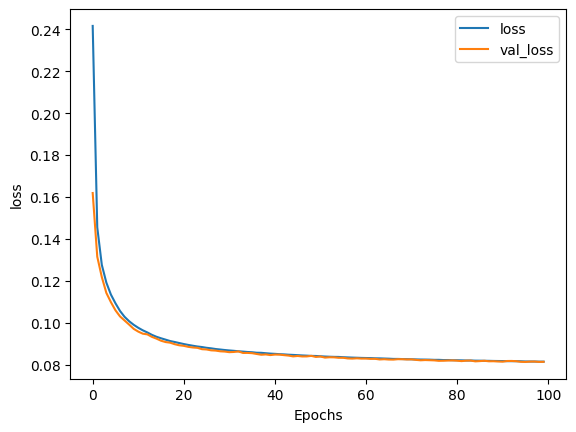

In [ ]:
historyx=history.history
loss=historyx['loss']
val_loss=historyx['val_loss']
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss','val_loss'])

get the output of the decoder from x_test input:

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 1ms/step


display the initial images and their corresponding decoded ones:

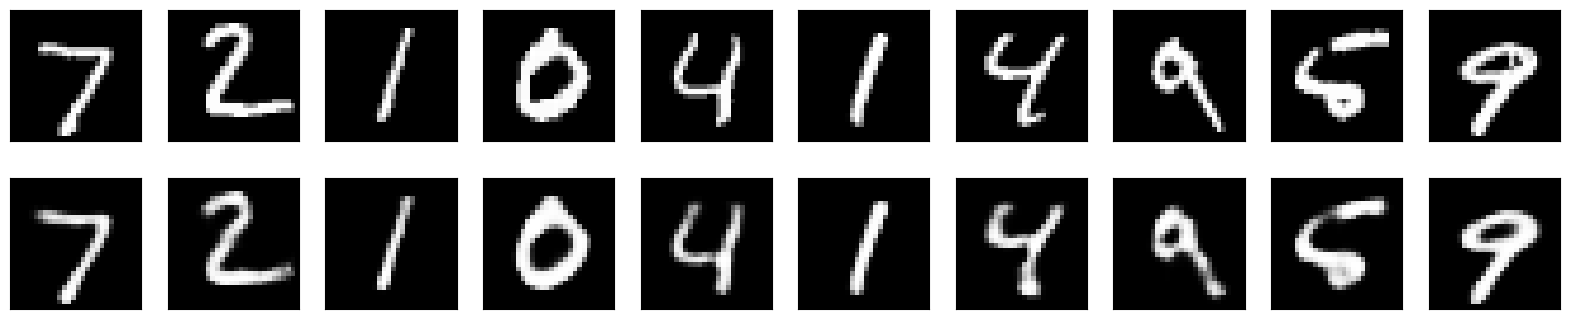

In [ ]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

display the images in latent space (output of encoder):

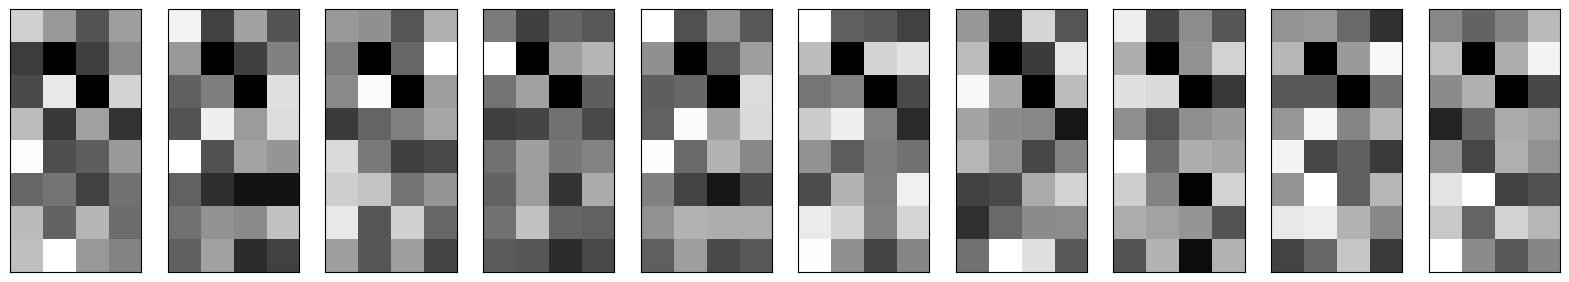

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((LATENT_SPACE_WIDTH, LATENT_SAPCE_HEIGHT)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

apply noise to the dataset:

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

display noisy images:

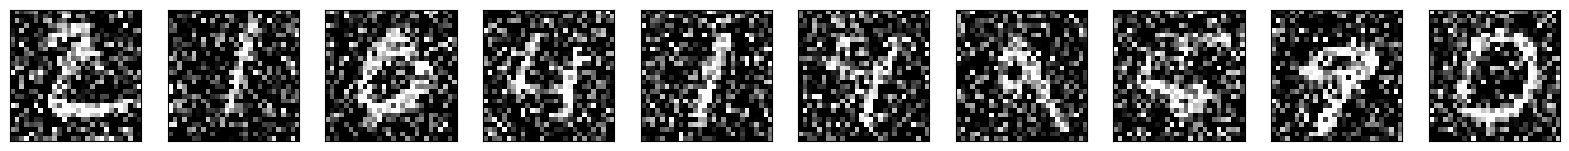

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

train the model based on noisy input and real target:

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1492 - val_loss: 0.1280
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1253 - val_loss: 0.1222
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1217 - val_loss: 0.1204
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1202 - val_loss: 0.1198
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1194 - val_loss: 0.1190
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.1187 - val_loss: 0.1192
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1183 - val_loss: 0.1181
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1178 - val_loss: 0.1175
Epoch 9/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1174 - val_loss: 0.1176
Epoch 10/100
469/469 [==============================] - 2s 5ms/step - loss: 0.1171 - val_lo

In [ ]:
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(LATENT_SAPCE_DIM,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer)


In [ ]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 1ms/step


show the noisy images and their corresponding denoised one using the trained model:

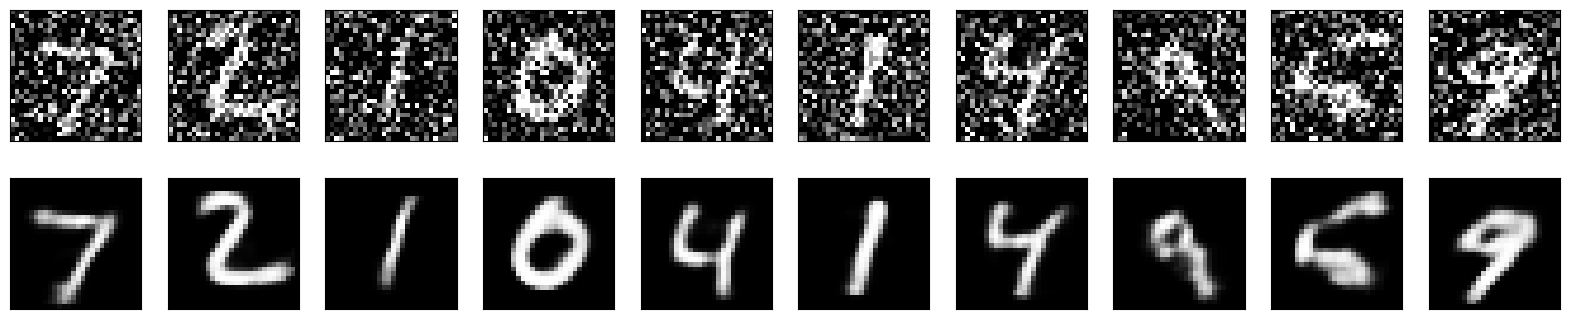

In [ ]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

save the models:

In [ ]:
autoencoder.save("autoencoder.h5")
encoder.save("encoder.h5")
decoder.save("decoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


plot histogram of the weights of first layer:

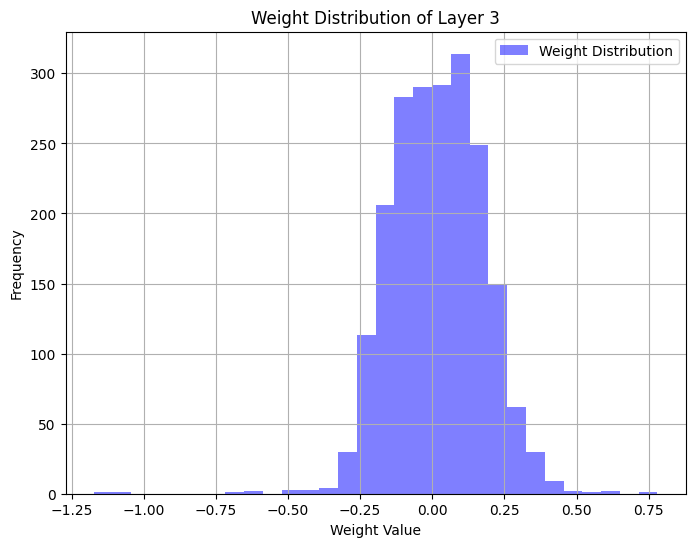

In [ ]:
layer_weights = encoder.layers[3].get_weights()

# Plot the weight distribution
if layer_weights:
    weights = layer_weights[0]

    plt.figure(figsize=(8, 6))
    plt.hist(weights.flatten(), bins=30, alpha=0.5, color='b', label='Weight Distribution')
    plt.title(f'Weight Distribution of Layer {3}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

## Quantization

post quantize input and output to 16 bits width having 14 bits fraction:

In [ ]:
x_train2 = fp_quantize(x_train, 17, 14)
x_test2 = fp_quantize(x_test, 17, 14)
x_train_noisy_2 = fp_quantize(x_train_noisy, 17, 14)
x_test_noisy_2 = fp_quantize(x_test_noisy, 17, 14)

define the quantization model using "qkeras" model:

In [ ]:
input_img = keras.Input(shape=(x_train2.shape[1],))
encoded = QDense(128, kernel_quantizer=quantized_bits(8, 1, alpha=1), bias_quantizer=quantized_bits(8, 1, alpha=1))(input_img)
encoded = QActivation(activation=quantized_relu(8, 1))(encoded)
encoded = QDense(64, kernel_quantizer=quantized_bits(8, 1, alpha=1), bias_quantizer=quantized_bits(8, 1, alpha=1))(encoded)
encoded = QActivation(activation=quantized_relu(8, 1))(encoded)
encoded = QDense(LATENT_SAPCE_DIM, kernel_quantizer=quantized_bits(16, 2, alpha=1), bias_quantizer=quantized_bits(16, 2, alpha=1))(encoded)
encoded = QActivation(activation=quantized_relu(16, 2))(encoded)

decoded = QDense(64, kernel_quantizer=quantized_bits(8, 1, alpha=1), bias_quantizer=quantized_bits(8, 1, alpha=1))(encoded)
decoded = QActivation(activation=quantized_relu(8, 1))(decoded)
decoded = QDense(128, kernel_quantizer=quantized_bits(8, 1, alpha=1), bias_quantizer=quantized_bits(8, 1, alpha=1))(decoded)
decoded = QActivation(activation=quantized_relu(8, 1))(decoded)
decoded = QDense(x_train2.shape[1], kernel_quantizer=quantized_bits(16, 2, alpha=1), bias_quantizer=quantized_bits(16, 2, alpha=1), activation='sigmoid')(decoded)

qautoencoder = keras.Model(input_img, decoded)

In [ ]:
qautoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 q_dense (QDense)            (None, 128)               100480    
                                                                 
 q_activation (QActivation)  (None, 128)               0         
                                                                 
 q_dense_1 (QDense)          (None, 64)                8256      
                                                                 
 q_activation_1 (QActivatio  (None, 64)                0         
 n)                                                              
                                                                 
 q_dense_2 (QDense)          (None, 32)                2080      
                                                           

train the model (Quantization Aware Training):

In [ ]:
qautoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = qautoencoder.fit(x_train_noisy_2, x_train2,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy_2, x_test2))

Epoch 1/100
235/235 [==============================] - 8s 12ms/step - loss: 0.2866 - val_loss: 0.2249
Epoch 2/100
235/235 [==============================] - 2s 9ms/step - loss: 0.2083 - val_loss: 0.1928
Epoch 3/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1853 - val_loss: 0.1784
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1755 - val_loss: 0.1707
Epoch 5/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1687 - val_loss: 0.1643
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1632 - val_loss: 0.1610
Epoch 7/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1600 - val_loss: 0.1575
Epoch 8/100
235/235 [==============================] - 2s 8ms/step - loss: 0.1575 - val_loss: 0.1556
Epoch 9/100
235/235 [==============================] - 2s 9ms/step - loss: 0.1555 - val_loss: 0.1536
Epoch 10/100
235/235 [==============================] - 2s 7ms/step - loss: 0.1536 - val_l

define the encoder:

In [ ]:
qencoder = keras.Model(input_img, encoded)

define the decoder:

In [ ]:
encoded_input = keras.Input(shape=(LATENT_SAPCE_DIM,))
# Retrieve the last layer of the autoencoder model
decoder_layer = qautoencoder.layers[-5](encoded_input)
decoder_layer = qautoencoder.layers[-4](decoder_layer)
decoder_layer = qautoencoder.layers[-3](decoder_layer)
decoder_layer = qautoencoder.layers[-2](decoder_layer)
decoder_layer = qautoencoder.layers[-1](decoder_layer)
# Create the decoder model
qdecoder = keras.Model(encoded_input, decoder_layer)

get the outputs of the autoencoder:

In [ ]:
encoded_imgs = qencoder.predict(x_test_noisy_2)
decoded_imgs = qdecoder.predict(encoded_imgs)

313/313 [==============================] - 1s 3ms/step


display the noisy inputs and their corresponding output using the quantized model:

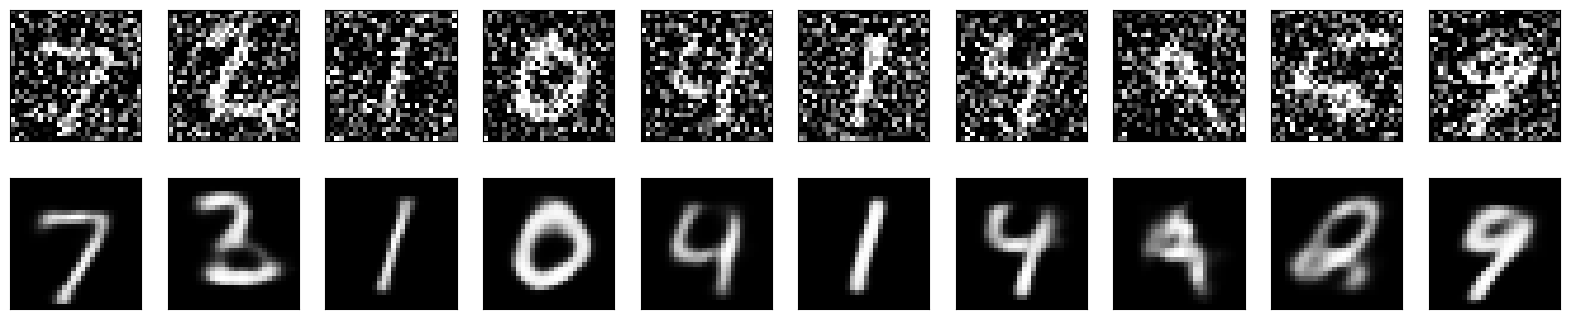

In [ ]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

save the models:

In [ ]:
qautoencoder.save("qautoencoder.h5")
qencoder.save("qencoder.h5")
qdecoder.save("qdecoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
 model_size_kb = os.path.getsize("/content/qautoencoder.h5") / 1024.0
 print(model_size_kb)

2683.4609375


In [ ]:
all_weights_auto_1 = autoencoder.get_weights();
#all_weights_qauto_1 = qautoencoder.get_weights();
all_weights_auto_2= [fp_quantize(np.array(w), 9, 7) for w in all_weights_auto_1]
#all_weights_qauto_2= [fp_quantize(np.array(w), 9, 7) for w in all_weights1]
all_weights_auto_1_x=np.array(all_weights_auto_1)

<ipython-input-41-ac5f08e02d9d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_weights_auto_1_x=np.array(all_weights_auto_1)


In [ ]:
np.where(all_weights_auto_1[0] > 0.00002)[0].shape[0];
#all_weights_auto_1_x
#all_weights_auto_1_x = all_weights_auto_1_x.astype('float32')

In [ ]:
c = 0
for w in all_weights_auto_1:
  print(w)
  print("---------------------------------")

In [ ]:
abs_list_1 = [
    [
        [abs(value) for value in inner_list]  # Innermost loop for the third dimension

    for inner_list in all_weights_auto_1  # Outermost loop for the first dimension
]]
abs_list_2=[
    [
        [abs(value) for value in inner_list]  # Innermost loop for the third dimension

    for inner_list in all_weights_auto_2  # Outermost loop for the first dimension
]]

In [ ]:
sumq=0.0
sum=0.0
for outer_list in abs_list_1:
  for inner_list in outer_list:
    print(type(inner_list))
    sumq+=np.sum(inner_list[:])
for outer_list in abs_list_2:
  for inner_list in outer_list:
    sum+=np.sum(inner_list[:])
sum

sumq

In [ ]:
def layer_weight_cal(layer,pres):
  w=layer.get_weights()
  '''abs_list_1 = [
    [
        [abs(value) for value in inner_list]

    for inner_list in w
  ]]'''
  #abs_list_1[0][-1]=np.array(abs_list_1[0][-1])
  N=0
  for outer_list in w:
    for inner_list in outer_list:
      if type(inner_list) == np.ndarray:
        for weight in inner_list:
          N+=1
      else :
        N+=1


  sum=N*(pres)
  sum/=1024.0
  sum/=8.0
  return sum


In [ ]:
print(layer_weight_cal(autoencoder.layers[1],33))

404.765625


In [ ]:
for i in range (len(autoencoder.layers)):
  volume=0.0
  volume=layer_weight_cal(autoencoder.layers[i],17)
  print("Volume of layer %d of Autoencoder is %3f KBs"%(i,volume))

Volume of layer 0 of Autoencoder is 0.000000 KBs
Volume of layer 1 of Autoencoder is 208.515625 KBs
Volume of layer 2 of Autoencoder is 17.132812 KBs
Volume of layer 3 of Autoencoder is 4.316406 KBs
Volume of layer 4 of Autoencoder is 4.382812 KBs
Volume of layer 5 of Autoencoder is 17.265625 KBs
Volume of layer 6 of Autoencoder is 209.876953 KBs


In [ ]:
def Network_weight_cal(network,pres):
  sum=0.0
  layers=len(network.layers)
  for i in range (layers):
    temp=0.0
    xlayer=network.layers[i]
    if xlayer.get_weights()!=[] :
      temp=layer_weight_cal(xlayer,pres)
    sum+=temp
  return sum
print("Volume of Autoencoder is %d KBs"%(Network_weight_cal(autoencoder,17)))
print("Volume of QAutoencoder is %d KBs"%(Network_weight_cal(qautoencoder,9)))

Volume of Autoencoder is 461 KBs
Volume of QAutoencoder is 244 KBs


# **Save Weights as Fixed Point**

In [ ]:
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
qencoder = keras.models.load_model('qencoder.h5', custom_objects=co)
qencoder.compile(optimizer='adam', loss='mse')

In [ ]:
x_test_noisy_2[0]

In [ ]:
یqencoder.predict(np.array([x_test2[0]]))

In [ ]:
WriteFixPToFile("input.txt", x_test2[0], 17, 14)

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')
os.mkdir('Weights_qencoder')
os.mkdir('Weights_qdecoder')
os.mkdir('Weights_qautoencoder')

In [ ]:
for i, layer in enumerate(qautoencoder.layers):
    weights = layer.get_weights()
    if weights and len(weights) > 0:
        w_per_neuron = weights[0].shape[0]
        w = np.einsum("ij->ji", weights[0]).reshape(-1,)
        b = weights[1].reshape(-1,)
        separate_weights = [np.concatenate((w[c:c+w_per_neuron], b[int(c/w_per_neuron):int(c/w_per_neuron)+1]), axis=0) for c in range(0, len(w), w_per_neuron)]

        width, f = (17, 14) if layer.name == 'last' else (9, 7)
        for n, s in enumerate(separate_weights):
            WriteFixPToFile(f"Weights_qautoencoder/layer_{i + 1}_{n + 1}_w.txt", s, width, f)

In [ ]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

folder_path = '/content/Weights_qdecoder'
zip_path = '/content/Weights_qdecoder_zipped.zip'

zip_folder(folder_path, zip_path)